# CustomerHarbor: Clustering Wholesale Customers for In-Depth Spending Insights

In [7]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import random


### data-set from https://archive.ics.uci.edu/dataset/292/wholesale+customers 

In [8]:
train_ = pd.read_csv('Wholesale customers data.csv')
train_ = train_.drop(['Channel','Region'],axis=1)


In [9]:
# checking for outliers
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
md = MinCovDet().fit(train_)
md_dist=md.mahalanobis(train_)
threshold = chi2.ppf(0.9999, df=train_.shape[1])
outliers = train_[md_dist>threshold]
outliers.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,16728.727273,13224.102273,17978.090909,5992.500000,7305.159091,3528.227273
std,20277.396597,12744.341627,15508.893002,9193.523439,8372.098471,5686.206197
min,3.000000,333.000000,572.000000,36.000000,15.000000,3.000000
25%,2433.250000,4391.250000,6608.750000,867.750000,745.750000,914.250000
50%,8884.500000,9285.500000,15713.500000,2386.000000,4622.000000,2305.000000
75%,25797.750000,17081.000000,24175.500000,7471.500000,12080.000000,4442.000000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Picking the right number of Cluster/centroids

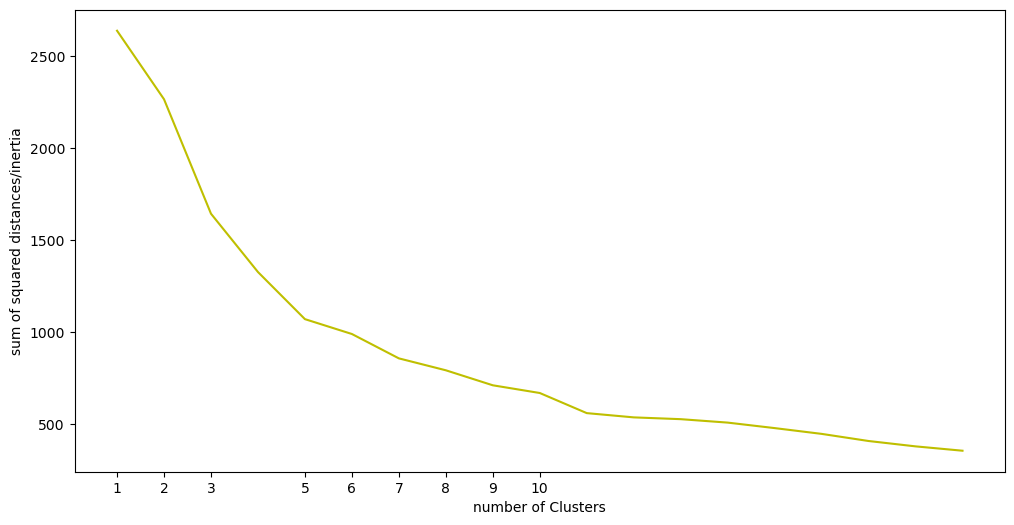

In [10]:
#since KMeans is sensetive to the scale of featuresfrom sklearn.preprocessing import StandardScaler

train=StandardScaler().fit_transform(train_)
inertias=[]
n_K=range(1,20)
X_train=train
for x in n_K:
    model = KMeans(n_clusters=x,random_state=42).fit(X_train)
    yhat = model.predict(X_train)
    inertias.append(model.inertia_)
    
plt.figure(figsize=(12,6))
plt.xlabel('number of Clusters')
plt.ylabel('sum of squared distances/inertia')
plt.plot(n_K,inertias , c='y')    
plt.xticks([1,2,3,5,6,7,8,9,10])
plt.show()

####    ! there seems to be an elbow on either 3 or 5 but upon further trail and error i picked 3 

In [11]:
## creating the model with n_clusters = 3

model = KMeans(n_clusters=5,random_state=4).fit(train)
yhat = model.predict(train)

### Visualizing The Clusters

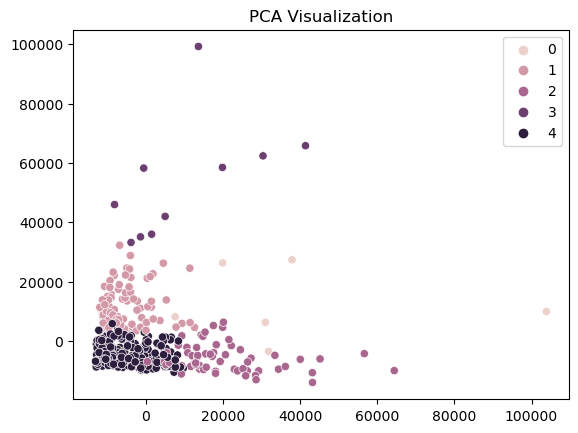

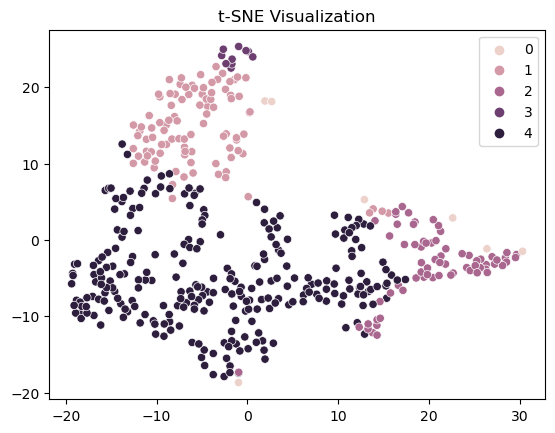

In [12]:
Reduced_df = PCA(n_components=2,random_state=42).fit_transform(train_)
sns.scatterplot(x=Reduced_df[:,0], y = Reduced_df[:,1],hue=yhat)
plt.title('PCA Visualization')

plt.show()

tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(train_)

sns.scatterplot(x=embedded_data[:, 0], y=embedded_data[:, 1], hue=yhat)
plt.title('t-SNE Visualization')

plt.show()

In [13]:
with open('clusters.csv','w',newline='') as csvfile:
    csvv=csv.writer(csvfile)
    csvv.writerows(np.array(yhat).reshape(-1,1))


### Understanding Each Group Of Customers

In [14]:
trained_0 = train_[yhat==0]
trained_1 =train_[yhat==1]
trained_2 =train_[yhat==2]
trained_3 =train_[yhat==3]
trained_4 =train_[yhat==4]

In [15]:
groups_data = {
    'Group 1': np.mean(trained_0, axis=0),
    'Group 2': np.mean(trained_1, axis=0),
    'Group 3': np.mean(trained_2, axis=0),
    'Group 4': np.mean(trained_3, axis=0),
    'Group 5': np.mean(trained_4, axis=0),
}

groups_df = pd.DataFrame(groups_data)

groups_df = groups_df.round(2).T

pd.DataFrame(groups_df).head(10)



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Group 1,40136.86,19452.14,15026.29,23713.71,2374.14,15735.14
Group 2,5509.25,10555.64,16477.93,1420.12,7199.41,1658.79
Group 3,31516.57,4257.57,5007.90,5739.82,761.00,1817.07
Group 4,15964.90,34708.50,48536.90,3054.60,24875.20,2942.80
Group 5,8368.76,2950.78,3805.37,2426.52,1002.30,959.71


### Making Targeting Marketing sections for each group

In [16]:
n_clusters=5
for i in range(n_clusters):
    trained = train[yhat==i]
    ## normalizing the spending to get the relative scale
    norm_mean = (np.mean(trained,axis=0) - train.mean())
    
    max_sec =np.argsort(norm_mean)[-2:]
    top_categories =train_.columns[max_sec]
    print(f'Top two categories for group {i+1}: {top_categories[0]} and {top_categories[1]}')


Top two categories for group 1: Frozen and Delicassen
Top two categories for group 2: Grocery and Detergents_Paper
Top two categories for group 3: Frozen and Fresh
Top two categories for group 4: Grocery and Detergents_Paper
Top two categories for group 5: Delicassen and Frozen


In [17]:
with open('groupings.csv', 'w', newline='') as csvfile:
    csvf = csv.writer(csvfile)
    
    ## Writing header with group count
    csvf.writerow([
        'Characteristics', 
        f'Group 1 (Mean: {len(trained_0)} customers)', 
        f'Group 2 (Mean: {len(trained_1)} customers)', 
        f'Group 3 (Mean: {len(trained_2)} customers)', 
        f'Group 4 (Mean: {len(trained_3)} customers)', 
        f'Group 5 (Mean: {len(trained_4)} customers)'
    ])
    
    ## Writing mean values for each group
    for i, trained_group in enumerate([trained_0, trained_1, trained_2, trained_3, trained_4]):
        mean_values = np.mean(trained_group, axis=0)
        
        # Writing mean values with original feature/columns names as index
        csvf.writerow([train_.columns[i]] + [f'%.2f' % value for value in mean_values])


In [18]:
trained_0.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,40136.857143,19452.142857,15026.285714,23713.714286,2374.142857,15735.142857
std,33563.725014,17346.467762,7517.329994,21231.603391,2058.466616,15086.474643
min,11314.000000,1266.000000,2062.000000,5154.000000,71.000000,2698.000000
25%,22332.000000,4057.500000,10871.500000,5842.500000,755.500000,7079.500000
50%,32717.000000,16784.000000,18148.000000,16745.000000,1579.000000,14351.000000
75%,40056.000000,33025.000000,20606.000000,35771.500000,4255.000000,15497.500000
max,112151.000000,43950.000000,22019.000000,60869.000000,4948.000000,47943.000000


In [19]:
trained_1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,5509.250000,10555.635417,16477.927083,1420.125000,7199.406250,1658.791667
std,5608.393263,4969.005312,6275.150686,1500.946258,3342.350763,1562.830205
min,18.000000,1275.000000,4748.000000,25.000000,282.000000,3.000000
25%,1357.000000,7079.500000,11529.500000,427.250000,4950.250000,590.250000
50%,3913.000000,9721.000000,14870.500000,946.000000,6756.500000,1333.000000
75%,7531.500000,12757.750000,20318.750000,1816.750000,8757.250000,2157.250000
max,24653.000000,25862.000000,36486.000000,10155.000000,17120.000000,7844.000000


In [20]:
trained_2.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,31516.573529,4257.573529,5007.897059,5739.823529,761.000000,1817.073529
std,12544.174342,3384.166179,3639.994941,4770.329395,940.424055,1390.686970
min,11243.000000,134.000000,218.000000,127.000000,9.000000,3.000000
25%,23395.500000,1875.250000,2308.000000,1726.250000,210.000000,831.250000
50%,28079.000000,3581.000000,4212.000000,4494.500000,424.000000,1422.000000
75%,37475.250000,5187.250000,7056.250000,8732.250000,836.500000,2518.250000
max,76237.000000,16687.000000,16966.000000,18711.000000,4621.000000,6854.000000


In [21]:
trained_3.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000
mean,15964.900000,34708.500000,48536.90000,3054.600000,24875.200000,2942.800000
std,14394.616621,19308.486409,20553.47215,2689.795994,8250.298699,1966.992504
min,85.000000,4980.000000,26866.00000,36.000000,17740.000000,903.000000
25%,6741.750000,24217.750000,32482.00000,996.750000,19032.000000,1360.750000
50%,10658.500000,29109.000000,42761.00000,2924.000000,22120.500000,2443.500000
75%,21223.000000,44240.000000,58591.25000,4365.500000,26083.500000,4576.750000
max,44466.000000,73498.000000,92780.00000,7782.000000,40827.000000,6465.000000


In [22]:
trained_4.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,8368.760618,2950.776062,3805.370656,2426.517375,1002.297297,959.706564
std,5908.097616,2444.271411,2807.557841,2785.208072,1200.288644,892.345988
min,3.000000,55.000000,3.000000,47.000000,3.000000,3.000000
25%,3174.000000,1115.000000,1748.000000,678.500000,202.500000,327.000000
50%,7588.000000,2160.000000,2861.000000,1455.000000,445.000000,693.000000
75%,12366.500000,3986.500000,5245.000000,3010.000000,1330.500000,1297.000000
max,23257.000000,18664.000000,16483.000000,17866.000000,5316.000000,5137.000000
